# The Big Bang Theory Exploratory Data Analysis

### Imports:

In [4]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta, time

## Loading sample data file:

In [5]:
with open("data/DT_2/Raw/S1/The Big Bang_S0101.json", 'r') as file:
    s1e1Data = json.load(file)

In [7]:
# two different time formats in data, this cleans them into datetime objects
def string2datetime(string):
    try:
        return datetime.strptime(string.strip(), '%H:%M:%S:%f')

    except ValueError:
        try:
            return datetime.strptime(string.strip(), '%H:%M:%S,%f')
        
        except ValueError:
            return datetime.strptime(string.strip(), '%H:%M:%S')


In [8]:
def datetime2String(date):
    return datetime.strftime(date, '%H:%M:%S:%f')

In [9]:
def findHumor(file_path1, file_path2):
    humor_dict = {}
    for file_path in [file_path1, file_path2]:
        # print(file_path.upper())
        with open(file_path, 'r') as file:
            data = json.load(file)
            for dialog_num, info in data.items():
                if info['GT'] == 1:
                    # print("humor")
                    humor_start, humor_end = string2datetime(info["Humor Start Time"]), string2datetime(info["Humor End Time"])
                    duration = humor_end - humor_start
                    if timedelta(seconds=0) <= duration < timedelta(seconds=10):
                        humor_dict[humor_start] = humor_end
    return dict(sorted(humor_dict.items(), key=lambda x: x[0]))
    

In [10]:
def reorganize_data(file):
    lines_dict = {}
    for dialog_num, info in file.items():            
        dialog_turns = [key for key in info if key.startswith('Dialog Turn')]
        for turn in dialog_turns:
            start_time = string2datetime(info[turn]["Dialog Start time"])
            if start_time in lines_dict: 
                pass
            else:
                lines_dict[start_time] = {
                    "Scene": info["Scene"],
                    "Recipients": info[turn]["Recipients"],
                    "Speaker": info[turn]["Speaker"],
                    "Dialogue": info[turn]["Dialog"],
                    "Dialogue Start Time": string2datetime(info[turn]["Dialog Start time"]),
                    "Dialogue End Time": string2datetime(info[turn]["Dialog End time"])
                }

    return dict(sorted(lines_dict.items(), key=lambda x: x[0]))

            
        
        

In [11]:
path1 = "data/DT_2/Raw/S1/The Big Bang_S0101.json"
path2 = "data/DT_3/Raw/S1/The Big Bang_S0101.json"

humor_dict = findHumor(path1, path2)

In [12]:
lines_dict = reorganize_data(s1e1Data)

In [13]:
# TODO: set buffer
buffer = timedelta(seconds=1)

nHumorMissingLine = 0
idxsHumorMissingLine = []

humor_times = list(humor_dict.keys())
dialog_times = list(lines_dict.keys())
humorN = 0
dialogN = 0
while humorN < len(humor_dict):
    found_humor = False
    while dialogN < len(dialog_times) - 1 and not found_humor:
        laugh_start = humor_times[humorN]
        laugh_end = humor_dict[laugh_start]
        duration = laugh_end - laugh_start            
        
        current_dialog_start = dialog_times[dialogN]
        current_dialog_end = lines_dict[current_dialog_start]['Dialogue End Time']
        next_dialog_start = dialog_times[dialogN + 1]

        if current_dialog_start <= laugh_start < next_dialog_start and laugh_start <= (current_dialog_end + buffer):
            lines_dict[current_dialog_start]['isHumor'] = True
            lines_dict[current_dialog_start]['humorDuration'] = duration
            
            # print("Humor line: ", lines_dict[current_dialog_start]['Dialogue'])
            # print("Humor duration: ", humor_dict[laugh_start] - laugh_start)
            # print("Speaker: ", lines_dict[current_dialog_start]['Speaker'])
            # # print("\n")
            # print(f"Dialogue start: {lines_dict[current_dialog_start]['Dialogue Start Time']}")
            # print(f"Dialogue end: {lines_dict[current_dialog_start]['Dialogue End Time']}")
            # print(f"Humor start: {laugh_start}")
            # print("Humor end: ", humor_dict[laugh_start])
            # print("\n\n")
            found_humor = True
        dialogN += 1

    if not found_humor:
        dialogN = 0
        nHumorMissingLine += 1
        idxsHumorMissingLine.append(humorN)

    humorN += 1

In [14]:
# startTime and endTime must be in format String: "HH:MM:SS"
def getLinesBetween(startTime, endTime, lines_dict):
    
    return {
        lineStartTime: data
        for lineStartTime, data in lines_dict.items()
        if  string2datetime(startTime) <= lineStartTime <= string2datetime(endTime)}

## Instances where humor wasn't matched with a line 

In [15]:
def missingHumorInfo(missingHumorIndex):
    missingHumor = {}
    before_time = None
    after_time = None
    for index in missingHumorIndex:
        humorStart = humor_times[index]
        humorEnd = humor_dict[humorStart]

        for time_key in lines_dict.keys():
            if time_key < humorStart:
                before_time = time_key
            elif time_key > humorStart:
                after_time = time_key
                break

        missingHumor[humorStart] = {"Humor Start": humorStart,
                                    "Humor End": humorEnd,
                                    "Humor Duration":humorEnd-humorStart,
                                    "DialogEnd to HumorStart": humorStart - lines_dict[before_time]['Dialogue End Time'],
                                    "HumorEnd to NextDialogStart": lines_dict[after_time]['Dialogue Start Time'] - humorEnd
                                    }
        
    return missingHumor

In [19]:
missingHumorDict = missingHumorInfo(idxsHumorMissingLine)
missingHumorDict


{datetime.datetime(1900, 1, 1, 0, 0, 28): {'Humor Start': datetime.datetime(1900, 1, 1, 0, 0, 28),
  'Humor End': datetime.datetime(1900, 1, 1, 0, 0, 29),
  'Humor Duration': datetime.timedelta(seconds=1),
  'DialogEnd to HumorStart': datetime.timedelta(seconds=2, microseconds=940000),
  'HumorEnd to NextDialogStart': datetime.timedelta(microseconds=150000)},
 datetime.datetime(1900, 1, 1, 0, 0, 57): {'Humor Start': datetime.datetime(1900, 1, 1, 0, 0, 57),
  'Humor End': datetime.datetime(1900, 1, 1, 0, 0, 59),
  'Humor Duration': datetime.timedelta(seconds=2),
  'DialogEnd to HumorStart': datetime.timedelta(seconds=5, microseconds=820000),
  'HumorEnd to NextDialogStart': datetime.timedelta(microseconds=120000)},
 datetime.datetime(1900, 1, 1, 0, 2, 25): {'Humor Start': datetime.datetime(1900, 1, 1, 0, 2, 25),
  'Humor End': datetime.datetime(1900, 1, 1, 0, 2, 30),
  'Humor Duration': datetime.timedelta(seconds=5),
  'DialogEnd to HumorStart': datetime.timedelta(seconds=4, microsecond

In [36]:
#### Plotting missing humor dialogEnd to humorStart
dilogEnd2humorStart = []
for key, val in missingHumorDict.items():
    if val["DialogEnd to HumorStart"].days == 0:
        dilogEnd2humorStart.append(val["DialogEnd to HumorStart"].total_seconds())

dilogEnd2humorStart


[2.94,
 5.82,
 4.98,
 1.77,
 2.77,
 2.88,
 1.77,
 1.79,
 2.78,
 1.98,
 2.88,
 6.81,
 1.9,
 7.9]

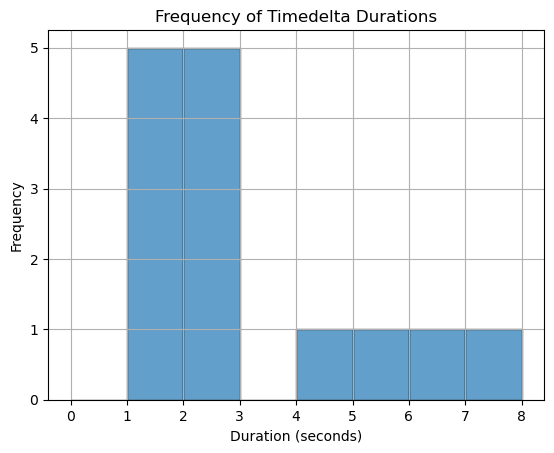

In [38]:
bins = np.arange(0, max(dilogEnd2humorStart) + 1, 1)  # Bins from 0 to maximum duration in seconds with step size of 1

# Plot histogram
plt.hist(dilogEnd2humorStart, bins=bins, edgecolor='black', alpha=0.7)
plt.xlabel('Duration (seconds)')
plt.ylabel('Frequency')
plt.title('Frequency of Timedelta Durations')
plt.xticks(bins)
plt.grid(True)
plt.show()

In [ ]:
from pathlib import Path

In [225]:
directory = Path("data/DT_2/Raw")

for file_path in directory.rglob('*'):
    if file_path.is_file():
        with open(file_path, 'r') as rFile:
            data = json.load(rFile)
            humor_dict = findHumor(file_path)
            lines_dict = reorganize_data(data)
        
        new_file_path = "cleaned-" + str(file_path).replace("/DT_2/Raw", "")
        
        with open(new_file_path, 'w') as wFile:
            json.dump(lines_dict)
    # if not directory.exists():
    #     directory.mkdir(parents=True, exist_ok=True)

cleaned-data/.DS_Store
cleaned-data/S5/The Big Bang_S0511.json
cleaned-data/S5/The Big Bang_S0507.json
cleaned-data/S5/The Big Bang_S0506.json
cleaned-data/S5/The Big Bang_S0510.json
cleaned-data/S5/The Big Bang_S0521.json
cleaned-data/S5/The Big Bang_S0517.json
cleaned-data/S5/The Big Bang_S0501.json
cleaned-data/S5/The Big Bang_S0516.json
cleaned-data/S5/The Big Bang_S0520.json
cleaned-data/S5/The Big Bang_S0523.json
cleaned-data/S5/The Big Bang_S0519.json
cleaned-data/S5/The Big Bang_S0503.json
cleaned-data/S5/The Big Bang_S0515.json
cleaned-data/S5/The Big Bang_S0514.json
cleaned-data/S5/The Big Bang_S0502.json
cleaned-data/S5/The Big Bang_S0518.json
cleaned-data/S5/The Big Bang_S0522.json
cleaned-data/S5/The Big Bang_S0505.json
cleaned-data/S5/The Big Bang_S0513.json
cleaned-data/S5/The Big Bang_S0509.json
cleaned-data/S5/The Big Bang_S0508.json
cleaned-data/S5/The Big Bang_S0512.json
cleaned-data/S5/The Big Bang_S0504.json
cleaned-data/S2/The Big Bang_S0205.json
cleaned-data/S2/T